In [29]:
import numpy as np
import sympy as sym
from sympy import Matrix,Symbol,zeros,eye,Array,cos,sin,pi
from urdf_parser_py.urdf import URDF
import xacro
# import urdfpy

In [31]:
robot = URDF()

In [32]:
dir(robot)

['SUPPORTED_VERSIONS',
 'XML_REFL',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'add_aggregate',
 'add_aggregates_to_xml',
 'add_joint',
 'add_link',
 'aggregate_init',
 'aggregate_order',
 'aggregate_type',
 'check_valid',
 'child_map',
 'from_parameter_server',
 'from_xml',
 'from_xml_file',
 'from_xml_string',
 'gazebos',
 'get_aggregate_list',
 'get_chain',
 'get_refl_vars',
 'get_root',
 'joint_map',
 'joints',
 'link_map',
 'links',
 'lump_aggregates',
 'materials',
 'name',
 'parent_map',
 'parse',
 'post_read_xml',
 'pre_write_xml',
 'read_xml',
 'remove_aggregate',
 'to_xml',
 'to_xml_string',
 'to_yaml',
 'transmissions',
 'version',
 'write_xml']

In [63]:
def extract_inertia_matrix(urdf_file):
    """
    Extract the inertia matrix of a robot from a URDF file.
    
    Args:
        urdf_file: Path to the URDF file
        
    Returns:
        inertia_matrix: 3x3 inertia matrix for each link of the robot
    """
    
    robot = URDF()
    robot = robot.from_xml_file(urdf_file)
    inertia_matrix = {}

    for link in robot.links:
        inertial = link.inertial
        if inertial is not None:
            inertia = inertial.inertia
            inertia_matrix[link.name] = np.array([
                [inertia.ixx, inertia.ixy, inertia.ixz],
                [inertia.ixy, inertia.iyy, inertia.iyz],
                [inertia.ixz, inertia.iyz, inertia.izz]
            ])
    
    return inertia_matrix

In [51]:
def extract_dh_parameters(urdf_file):
    """
    Extract the Denavit-Hartenberg (DH) parameters from a URDF file.
    
    Args:
        urdf_file: Path to the URDF file
        
    Returns:
        dh_parameters: List of DH parameters [a, alpha, d, theta] for each joint
    """
    robot = URDF()
    robot = robot.from_xml_file(urdf_file)
    dh_parameters = []

    for joint in robot.joints:
        if joint.type != 'fixed':
            origin = joint.origin
            link = joint.child

            dh = [0.0, 0.0, 0.0, 0.0]

            for link_elem in robot.links:
                if link_elem.name == link:
                    dh[0] = link_elem.visual.origin.xyz[0]
                    dh[1] = link_elem.visual.origin.xyz[1]
                    dh[2] = link_elem.visual.origin.xyz[2]

            dh[3] = origin.rpy[2]
            
            dh_parameters.append(dh)
    
    return dh_parameters

In [52]:
def calculate_jacobian(theta, lengths, offsets):
    """
    Calculate the Jacobian matrix for a 6-DOF robot arm.
    
    Args:
        theta: List of joint angles in radians [theta1, theta2, ..., theta6]
        lengths: List of link lengths [a1, a2, ..., a6]
        offsets: List of joint offsets [d1, d2, ..., d6]
    
    Returns:
        jacobian: The 6x6 Jacobian matrix
    """
    jacobian = np.zeros((6, 6))
    
    # Forward kinematics
    T = np.eye(4)
    for i in range(6):
        theta_i = theta[i]
        length_i = lengths[i]
        offset_i = offsets[i]
        
        # Calculate transformation matrix for current joint
        cos_theta = np.cos(theta_i)
        sin_theta = np.sin(theta_i)
        cos_alpha = np.cos(offset_i)
        sin_alpha = np.sin(offset_i)
        
        T_i = np.array([
            [cos_theta, -sin_theta * cos_alpha, sin_theta * sin_alpha, length_i * cos_theta],
            [sin_theta, cos_theta * cos_alpha, -cos_theta * sin_alpha, length_i * sin_theta],
            [0, sin_alpha, cos_alpha, offset_i],
            [0, 0, 0, 1]
        ])
        
        # Update overall transformation matrix
        T = np.matmul(T, T_i)
        
        # Calculate linear and angular velocities for the current joint
        z_axis = T[:3, 2]
        p_i = T[:3, 3]
        linear_velocity = np.cross(z_axis, p_i)
        angular_velocity = z_axis
        
        # Update Jacobian matrix
        jacobian[:, i] = np.concatenate((linear_velocity, angular_velocity))
    
    return jacobian

In [60]:
URDF_FILE = 'robot.urdf'

inertia_matrix = list(extract_inertia_matrix(URDF_FILE).values())

# Print inertia matrix for each link
print(inertia_matrix)

[array([[ 2.090e-03, -0.000e+00,  3.000e-06],
       [-0.000e+00,  2.086e-03,  0.000e+00],
       [ 3.000e-06,  0.000e+00,  1.141e-03]]), array([[ 8.17e-04, -0.00e+00, -0.00e+00],
       [-0.00e+00,  6.37e-04,  8.70e-05],
       [-0.00e+00,  8.70e-05,  3.88e-04]]), array([[ 2.370e-04,  1.700e-05,  1.000e-06],
       [ 1.700e-05,  2.441e-03, -0.000e+00],
       [ 1.000e-06, -0.000e+00,  2.532e-03]]), array([[ 1.52e-04, -5.50e-05, -0.00e+00],
       [-5.50e-05,  2.59e-04, -0.00e+00],
       [-0.00e+00, -0.00e+00,  3.37e-04]]), array([[ 8.40e-05,  0.00e+00, -6.00e-06],
       [ 0.00e+00,  2.01e-04, -1.00e-06],
       [-6.00e-06, -1.00e-06,  1.84e-04]]), array([[ 3.2e-05,  4.0e-06,  0.0e+00],
       [ 4.0e-06,  6.2e-05, -0.0e+00],
       [ 0.0e+00, -0.0e+00,  7.3e-05]]), array([[0.001875 , 0.       , 0.       ],
       [0.       , 0.0010875, 0.       ],
       [0.       , 0.       , 0.0010875]])]


In [62]:
dh_parameters = extract_dh_parameters(URDF_FILE)
DH_PARAMS = []

# Print DH parameters
print(dh_parameters) #a, alpha, d, theta


[[0.0, 0.0, -0.081, 0.0], [0.0, 0.032, -0.22, 0.0], [-0.2, 0.06762, -0.22, 0.0], [-0.2309, -0.01749, -0.22, 0.0], [-0.35625, -0.01749, -0.2395, 0.0]]


In [ ]:


# Example usage
theta = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6] # Joint angles in radians
lengths = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6] # Link lengths
offsets = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] # Joint offsets

jacobian = calculate_jacobian(theta, lengths, offsets)
print("Jacobian Matrix:")
print(jacobian)

In [3]:
def DH(alpha, a, d, theta):
    a11 = cos(theta)
    a12 = -sin(theta)*round(cos(alpha),2)
    a13 = sin(theta)*round(sin(alpha),2)
    a14 = a*cos(theta)

    a21 = sin(theta)
    a22 = cos(theta)*round(cos(alpha),2)
    a23 = -cos(theta)*round(sin(alpha),2)
    a24 = a*sin(theta)

    a31 = 0
    a32 = round(sin(alpha),2)
    a33 = round(cos(alpha),2)
    a34 =d

    a41 = 0
    a42 = 0
    a43 = 0
    a44 = 1


    trans_mat = Matrix([[a11, a12, a13, a14],
        [a21, a22, a23, a24],
        [a31, a32, a33, a34],
        [a41, a42, a43, a44]])

    return trans_mat

In [ ]:
L1 = 150
L2 = 200
L3 = 200
L4 = 45
L5 = 35
L6 = 25
n = 6

In [13]:
def inertial_params(symbol=True):
    ''' 
    Returns a struct with inertial parameters of 6 DOF MIR obtained from MIR's xacro file 
    '''

    def get_inertial_tensor_symbol(i):
        Ixx =Symbol(f'I{i}xx')
        Ixy =Symbol(f'I{i}xy')
        Ixz =Symbol(f'I{i}xz')
        Iyy =Symbol(f'I{i}yy')
        Iyz =Symbol(f'I{i}yz')
        Izz =Symbol(f'I{i}zz')

        return sym.Matrix([[Ixx, Ixy, Ixz],
                           [Ixy, Iyy, Iyz],
                           [Ixz, Iyz, Izz]])

    def get_cm_symbol(i):
        cx =Symbol(f'c{i}x')
        cy =Symbol(f'c{i}y')
        cz =Symbol(f'c{i}z')

        return sym.Array([cx, cy, cz])

    # Extract information from node
    # If enable == TRUE then numeric values are returned, else symbolic values are returned

    params = {
        'm': [0]*n,
        'I': zeros(3,3*n),
        'Cm': [0]*3*n,

    }
    if not symbol:
        params['m'][:] = [_m[key] for key in _m]
        params['I'][:, 0:3]= _I['I1']
        params['I'][:, 3:6] = _I['I2']
        params['I'][:, 6:9] = _I['I3']
        params['I'][:, 9:12] = _I['I4']
        params['I'][:, 12:15] = _I['I5']
        params['I'][:, 15:18] = _I['I6']

        params['Cm'][0:3] = _Cm['cm1']
        params['Cm'][3:6] = _Cm['cm2']
        params['Cm'][6:9] = _Cm['cm3']
        params['Cm'][9:12] = _Cm['cm4']
        params['Cm'][12:15] = _Cm['cm5']
        params['Cm'][15:18] = _Cm['cm6']

    else:
        m1 =Symbol('m1')
        m2 =Symbol('m1')
        m3 =Symbol('m3')
        m4 =Symbol('m4')
        m5 =Symbol('m5')
        m6 =Symbol('m6')

        params['m'] = sym.Matrix([m1, m2,m3,m4,m5,m6])  #6x1

        params['I'][:, 0:3] = get_inertial_tensor_symbol(1)
        params['I'][:, 3:6] = get_inertial_tensor_symbol(2)
        params['I'][:, 6:9] = get_inertial_tensor_symbol(3)
        params['I'][:, 9:12] = get_inertial_tensor_symbol(4)
        params['I'][:, 12:15] = get_inertial_tensor_symbol(5)
        params['I'][:, 15:18] = get_inertial_tensor_symbol(6)

        params['Cm'][0:3] = get_cm_symbol(1)
        params['Cm'][3:6] = get_cm_symbol(2)
        params['Cm'][6:9] = get_cm_symbol(3)
        params['Cm'][9:12] = get_cm_symbol(4)
        params['Cm'][12:15] = get_cm_symbol(5)
        params['Cm'][15:18] = get_cm_symbol(6)

    return params

In [14]:
#Forward kinematics and forward differential kinematics analysis of 6 DOF MIR

q1 = Symbol('q1')
q2 = Symbol('q2')
q3 = Symbol('q3')
q4 = Symbol('q4')
q5 = Symbol('q5')
q6 = Symbol('q6')
D1 = Symbol('D1')
D2 = Symbol('D2')
D3 = Symbol('D3')
D4 = Symbol('D4')
D5 = Symbol('D5')
D6 = Symbol('D6')
e2 = Symbol('e2')
aa = Symbol('aa')
d4b = Symbol('d4b')
d5b = Symbol('d5b')
d6b = Symbol('d6b')

D1 = 0.2755
D2 = 0.41
D3 = 0.2073
D4 = 0.0741
D5 = 0.0741
D6 = 0.16
e2 = 0.0098
aa = pi/6
d4b = D3 + sin(aa)/sin(2*aa)*D4
d5b = sin(aa)/sin(2*aa)*(D4+D5)
d6b = sin(aa)/sin(2*aa)*D5 + D6


#Forward kinematics
#Classic Denavit Hartenberg parameters
alpha = [pi/2, pi, pi/2, pi/3, pi/3, pi]
a = [0, D2, 0, 0, 0, 0]
d = [D1, 0, -e2, -d4b, -d5b, -d6b]
theta = [-q1, q2+pi/2, q3-pi/2, q4, q5+pi, q6-pi/2]


In [16]:

#Compute DH matrices
A = zeros(4,n*4)

A[:,0:4] = sym.simplify(DH(alpha[0], a[0], d[0], theta[0]))

for i in range(1,6):
    A[:,4*i:4*(i+1)] = sym.simplify(DH(alpha[i], a[i], d[i], theta[i]))


#Compute relative homogeneous transformation matrices
T1_0 = A[:,0:4]
T2_1 = A[:,4:8]
T3_2 = A[:,8:12]
T4_3 = A[:,12:16]
T5_4 = A[:,16:20]
T6_5 = A[:,20:24]

#Compute kinematic equation
T6_0 = T1_0 * T2_1 * T3_2 * T4_3 * T5_4 * T6_5 #homogeneous transformation matrix from frame 6 to frame 0
T6_0 = sym.simplify(T6_0)


# #End effector's rotation matrix
# r11 = T6_0[0,0]
# r21 = T6_0[1,0]
# r31 = T6_0[2,0]

# r12 = T6_0[0,1]
# r22 = T6_0[1,1]
# r32 = T6_0[2,1]

# r13 = T6_0[0,2]
# r23 = T6_0[1,2]
# r33 = T6_0[2,2]

# #End effector's position vector
# px = T6_0[0,3]
# py = T6_0[1,3]
# pz = T6_0[2,3]

In [23]:
# sym.pprint(T1_0)
# sym.pprint(T2_1)
# sym.pprint(T3_2)
# sym.pprint(T4_3)
# sym.pprint(T5_4)
# sym.pprint(T6_5)

In [21]:
#Forward differential kinematics
#Compute the homogeneous transformation matrices from frame i to inertial frame 0

T2_0 = sym.simplify(T1_0*T2_1)
T3_0 = sym.simplify(T2_0*T3_2)
T4_0 = sym.simplify(T3_0*T4_3)
T5_0 = sym.simplify(T4_0*T5_4)
T6_0 = sym.simplify(T5_0*T6_5)

#Extract position vectors from each homogeneous transformation matrix
# p0 = zeros(3,1) 
# p1 = T1_0[0:3,3]
# p2 = T2_0[0:3,3]
# p3 = T3_0[0:3,3]
# p4 = T4_0[0:3,3]
# p5 = T5_0[0:3,3]
# p6 = T6_0[0:3,3]

#Define vectors around which each link rotates in the precedent coordinate frame
z0 = Matrix([0,0,1])  #3x1

z1 = T1_0[0:3,2]
z2 = T2_0[0:3,2]
z3 = T3_0[0:3,2]
z4 = T4_0[0:3,2]
z5 = T5_0[0:3,2]
z6 = T6_0[0:3,2]

# print("Jacob started!")
# #Jacobian matrix
# j11 = z0.cross(p6-p0)
# j12 = z1.cross(p6-p1)
# j13 = z2.cross(p6-p2)
# j14 = z3.cross(p6-p3)
# j15 = z4.cross(p6-p4)
# j16 = z5.cross(p6-p5)

# j21 = z0
# j22 = z1
# j23 = z2
# j24 = z3
# j25 = z4
# j26 = z5

# J = sym.simplify(Matrix([[j11, j12, j13, j14, j15, j16],
#                 [j21, j22, j23, j24, j25, j26]]))  

# # Rounding
# J = J.n(2)

# #Extract linear jacobian
# Jl = J[0:3,:]

# #Extract angular jacobian
# Ja = J[3:,:]

In [38]:
# # Process xacro file


# Check if robot model is valid
# self.robot.check_valid()

# # self.matrices = Matrices()
_I = {
    "I1": [[0]*3]*3,
    "I2": [[0]*3]*3,
    "I3": [[0]*3]*3,
    "I4": [[0]*3]*3,
    "I5": [[0]*3]*3,
    "I6": [[0]*3]*3,
}
_m = {
    "m1": 0,
    "m2": 0,
    "m3": 0,
    "m4": 0,
    "m5": 0,
    "m6": 0,
}
_Cm = {
    "cm1": [0]*3,
    "cm2": [0]*3,
    "cm3": [0]*3,
    "cm4": [0]*3,
    "cm5": [0]*3,
    "cm6": [0]*3,
}

m_keys = list(_m.keys())
i_keys = list(_I.keys())
c_keys = list(_Cm.keys())

for i, link in enumerate(list(robot.link_map.keys())[1:n+1]):
    _m[m_keys[i]] = robot.link_map[link].inertial.mass
    inertia = robot.link_map[link].inertial.inertia
    _I[i_keys[i]][:] = [[inertia.ixx, inertia.ixy, inertia.ixz],
                              [inertia.ixy, inertia.iyy, inertia.iyz],
                              [inertia.ixz, inertia.iyz, inertia.izz]]
    _Cm[c_keys[i]][:] = robot.link_map[link].inertial.origin.xyz

In [39]:
_I,_Cm,_m

({'I1': [[0.00209, -0.0, 3e-06],
   [-0.0, 0.002086, 0.0],
   [3e-06, 0.0, 0.001141]],
  'I2': [[0.000817, -0.0, -0.0],
   [-0.0, 0.000637, 8.7e-05],
   [-0.0, 8.7e-05, 0.000388]],
  'I3': [[0.000237, 1.7e-05, 1e-06],
   [1.7e-05, 0.002441, -0.0],
   [1e-06, -0.0, 0.002532]],
  'I4': [[0.000152, -5.5e-05, -0.0],
   [-5.5e-05, 0.000259, -0.0],
   [-0.0, -0.0, 0.000337]],
  'I5': [[8.4e-05, 0.0, -6e-06],
   [0.0, 0.000201, -1e-06],
   [-6e-06, -1e-06, 0.000184]],
  'I6': [[3.2e-05, 4e-06, 0.0], [4e-06, 6.2e-05, -0.0], [0.0, -0.0, 7.3e-05]]},
 {'cm1': [0.00011256906932755121, 1.4557633150903527e-06, 0.05611303672311459],
  'cm2': [-2.1807382865401803e-05, -0.008667116088846339, 0.11122411445111006],
  'cm3': [0.10282542590700654, -0.0491995322220847, 3.6036445404369344e-05],
  'cm4': [0.025228490126899233, 0.07440941817736788, -6.26490712335448e-07],
  'cm5': [0.08541335998023963, 0.00029506558546724126, 0.0016735155042013894],
  'cm6': [0.015538378608286496, -0.002257603554561633, -0.019

In [42]:
# Inverse dynamics analysis of 6 DOF MIR

q1 =Symbol('q1')
q2 =Symbol('q2')
q3 =Symbol('q3')
q4 =Symbol('q4')
q5 =Symbol('q5')
q6 =Symbol('q6')
dq1 =Symbol('dq1')
dq2 =Symbol('dq2')
dq3 =Symbol('dq3')
dq4 =Symbol('dq4')
dq5 =Symbol('dq5')
dq6 =Symbol('dq6')
ddq1 =Symbol('ddq1')
ddq2 =Symbol('ddq2')
ddq3 =Symbol('ddq3')
ddq4 =Symbol('ddq4')
ddq5 =Symbol('ddq5')
ddq6 =Symbol('ddq6')

q = Matrix([q1, q2, q3, q4, q5, q6]) #6x1

dq = Matrix([dq1,dq2,dq3,dq4,dq5,dq6]) #6x1

ddq = Matrix([ddq1, ddq2,ddq3, ddq4, ddq5,ddq6])  #6x1

# Inertial parameters (Run inertial_params(False) to obtain numeric values or inertial_params(True) to obtain symbolic values

params = inertial_params(symbol=False)

# Mass of links
m = params['m']

# Inertia tensor of links
I1 = params['I'][:, 0:3]
I2 = params['I'][:, 3:6]
I3 = params['I'][:, 6:9]
I4 = params['I'][:, 9:12]
I5 = params['I'][:, 12:15]
I6 = params['I'][:, 15:18]

# Center of mass (COM) of links
com1 = params['Cm'][0:3]
com2 = params['Cm'][3:6]
com3 = params['Cm'][6:9]
com4 = params['Cm'][9:12]
com5 = params['Cm'][12:15]
com6 = params['Cm'][15:18]


In [48]:

# Compute inertia matrix D

k = Matrix([[1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, 0]])

# 4x4 4x4 4x1
r0_c1 = k * T1_0 * Matrix([*com1, 1])  #4x1
Jl_1 = r0_c1.jacobian(q)
Ja_1 = zeros(3, 6)
Ja_1[:,0] = z0

r0_c2 = k * T2_0 * Matrix([*com2, 1]) #4x1
Jl_2 = r0_c2.jacobian(q)

Ja_2 = zeros(3,6)
Ja_2[:,0] = z0
Ja_2[:,1] = z1


In [51]:


r0_c3 = k * T3_0 * Matrix([*com3 ,1]) #4x1
Jl_3 = r0_c3.jacobian(q)
Ja_3 = zeros(3,6)
Ja_3[:,0] = z0
Ja_3[:,1] = z1
Ja_3[:,2] = z2


r0_c4 = k * T4_0 * Matrix([*com4 ,1]) #4x1
Jl_4 = r0_c4.jacobian(q)
Ja_4 = zeros(3,6)
Ja_4[:,0] = z0
Ja_4[:,1] = z1
Ja_4[:,2] = z2
Ja_4[:,3] = z3

In [53]:
r0_c5 = k * T5_0 * Matrix([*com5 ,1]) #4x1
Jl_5 = r0_c5.jacobian(q)
Ja_5 = zeros(3,6)
Ja_5[:,0] = z0
Ja_5[:,1] = z1
Ja_5[:,2] = z2
Ja_5[:,3] = z3
Ja_5[:,4] = z4

r0_c6 = k * T6_0 * Matrix([*com6 ,1]) #4x1
Jl_6 = r0_c6.jacobian(q)
Ja_6 = zeros(3,6)
Ja_6[:,0] = z0
Ja_6[:,1] = z1
Ja_6[:,2] = z2
Ja_6[:,3] = z3
Ja_6[:,4] = z4
Ja_6[:,5] = z5

In [55]:

# Inertia matrix
D = sym.simplify(m[1] * Jl_1.T * Jl_1 + Ja_1.T * I1 * Ja_1) + \
    sym.simplify(m[2] * Jl_2.T * Jl_2 + Ja_2.T * I2 * Ja_2) + \
    sym.simplify(m[3] * Jl_3.T * Jl_3 + Ja_3.T * I3 * Ja_3) + \
    sym.simplify(m[4] * Jl_4.T * Jl_4 + Ja_4.T * I4 * Ja_4) + \
    sym.simplify(m[5] * Jl_5.T * Jl_5 + Ja_5.T * I5 * Ja_5) + \
    sym.simplify(m[6] * Jl_6.T * Jl_6 + Ja_6.T * I6 * Ja_6)

D = D.n(2)

In [ ]:

# Compute gravity vector g

g0 = [0, 0, -9.81] # gravity acceleration vector with respect to frame 0
Jl = [Jl_1, Jl_2, Jl_3, Jl_4, Jl_5, Jl_6]

g = zeros(6,1)  # gravity vector
for i in range(0,6):
    for j in range(i,6):
        g[i] = g[i] + m[j] * g0 * Jl[:,(j-1)*6+i]

g = g.n(2)
print("g finished")


In [ ]:

# Compute coriolis and centrifugal terms h

h = zeros(6,1)
for i in range(0,6):
    for j in range(0,6):
        for k in range(0,6):
            temp1 = q[k]
            temp2 = q[i]
            h[i] = h[i] + (sym.diff(D[i,j],temp1) - 0.5 * sym.diff(D[j,k],temp2))*dq[j]*dq[k]

h = h.n(2)
print("h finished")


In [1]:

# Final dynamic equation

tau = D * ddq + h + g
tau = tau.n(2)
print("tau finished")

# # Generating matlab scripts
inertia_mat = sym.lambdify(q,D,'numpy')
gravity_vector = sym.lambdify(q,g,'numpy')
coriolis_centrifugal_vec = sym.lambdify((q,dq),h,'numpy')

import inspect
a = inspect.getsource(inertia_mat)
b = inspect.getsource(gravity_vector)
c = inspect.getsource(coriolis_centrifugal_vec)

with open('i.py','w') as file:
    file.write(a)
with open('g.py','w') as file:
    file.write(b)
with open('c.py','w') as file:
    file.write(c)


print(inertia_mat,gravity_vector,coriolis_centrifugal_vec)

# matlabFunction(D, 'vars', {q}, 'file', 'inertiaMatrix', 'Optimize', false);
# matlabFunction(g, 'vars', {q}, 'file', 'gravityVector', 'Optimize', false);
# matlabFunction(h, 'vars', {q,dq}, 'file', 'cor_centriTerms', 'Optimize', false);

NameError: name 'D' is not defined

In [3]:
# DH matrix


# z0 for base
# z_(i-1) z_i

import matplotlib.pyplot as plt
import numpy as np

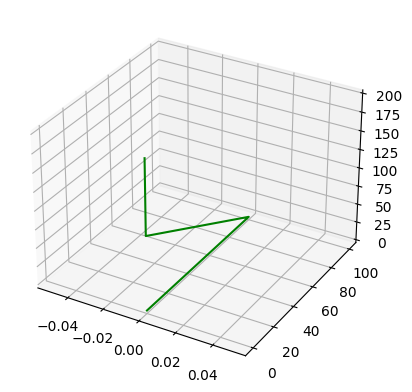

In [20]:
# nx3x1
n = 3
robot_i = np.array([[0,0,0],[0,0,100],[100,0,0],[200,0,0]]).reshape((-1,3))

fig = plt.figure()

ax = plt.axes(projection ='3d')

z = robot_i[:,0]
x = robot_i[:,1]
y = robot_i[:,2]

ax.plot3D(x, y, z, 'green')
ax.
plt.show()

In [ ]:
# DOF of robot arm
n = 2
# DH(alpha, a, theta, d)
DH = [[]]

# nx1 vector of joint variable
q = []

# nx1 vector of joint velocity
g_d = []

# nx1 vector of joint acceleration
q_dd

# nxnxn 3D matrix for transformation matrices
T = []

# 1xn grravity row vector
g = []

# nxn matrix representation of the effects of the motion of joint j on all the points of link i
# U_ij ~= del(0A_i)/del(q_i)
# U = [
#      U_ij : 0A_(j-1) * Q_j * (j-1)A_i if j<=i
#      U_ij : 0 else ]
U = []

# nxnxn matrix representation of the interraction between joints: the effects of the motion of 
# joint j & joint k on all the points of link i
# U_ijk ~= del(U_ij)/del(q_k)
# U = [
#      U_ijj : 0A_(j-1) * Q_j * (j-1)A_(k-1) * Q_k * (k-1)A_i if j<=k<=i 
#      U_ijj : 0A_(k-1) * Q_k * (k-1)A_(j-1) * Q_j * (j-1)A_i if k<=j<=i 
#      U_ijk : 0 else ]

U3 = []

# nxn inertial acceleration related matrix
D_qdd = []

# nx1 non-linear Coriolis & Centrifugal force vector
h_q_gd = []

# nx1 gravity loading force vector
c_q = []

# Generate D_qdd matrix
for i in range

In [1]:
import math
import numpy as np
from sympy import *

In [4]:
class Robot:
    def __init__(self,n=3):
        # Number of DOFs
        self.n = n

        # Link parameters (in m)
        # Link length
        l0 = 0.50
        l1 = 1.00
        l2 = 0.75

        # Link radii
        #L0
        d0 = 0.06
        r0 = 0.03 

        #L1
        d1 = 0.05
        r1 = 0.025 

        #L2
        d2 = 0.04
        r2 = 0.02 

        #L2
        # Link density (in kg/m^3)
        rho = 2710 

        # DH parameters
        # nx4 matrix of DH parameters
        self.DH_PARAMS = [[ 0,math.pi/2,l0,0],
                          [l1, 0  , 0,0],
                          [l2, 0  , 0,0]]

        # Link masses (in Kg)
        m0 = rho*(0.25*math.pi*d0**2*l0)
        m1 = rho*(0.25*math.pi*d1**2*l1)
        m2 = rho*(0.25*math.pi*d2**2*l2)

        self.link_masses = [m0,m1,m2]

        # Link Inertias (in Kgm^2)
        I0xx = 0.25*m0*r0**2 + 0.333*m0*l0**2  # At end
        I0yy = 0.25*m0*r0**2 + 0.33*m0*l0**2  # At end
        I0zz = 0.5*m0*r0**2 # At axis
        I0xy = 0
        I0xz = 0
        I0yz = 0

        I1xx = 0.5*m1*r1**2 # At axis
        I1yy = 0.25*m1*r1**2 + 0.333*m1*l1**2  # At end
        I1zz = 0.25*m1*r1**2 + 0.333*m1*l1**2  # At end
        I1xy = 0
        I1xz = 0
        I1yz = 0

        I2xx = 0.5*m2*r2**2 # At axis
        I2yy = 0.25*m2*r2**2 + 0.333*m2*l2**2  # At end
        I2zz = 0.25*m2*r2**2 + 0.333*m2*l2**2  # At end
        I2xy = 0
        I2xz = 0
        I2yz = 0
        self.r_bar = np.array([[0,0,l0/2,1],
                                [l1/2,0,0,1],
                                [l2/2,0,0,1]]).T
        self.link_inertias = [[I0xx,I0yy,I0zz,I0xy,I0xz,I0yz],
                  [I1xx,I1yy,I1zz,I1xy,I1xz,I1yz],
                  [I2xx,I2yy,I2zz,I2xy,I2xz,I2yz]]

In [39]:
class DynamicsEquationGenerator:
    def __init__(self,robot):
        # Robot structure
        self.robot = robot

        # No. DOFs
        self.n = self.robot.n

        # 1xn row vector of link masses
        self.m = self.robot.link_masses

        # 1xn vector of 4x4 inertia matrices
        self.J = [self.inertia_tensor(self.robot.link_inertias[i],self.m[i],self.robot.r_bar[:,i]) for i in range(self.n)]

        # nx1 vector of joint variable / generalized coordinates (DH parameter theta)
        self.q = Matrix([ [q_] for q_ in symbols(f'q:{self.n}')])

        # nx1 vector of joint velocity
        self.q_d = Matrix([ [q_] for q_ in symbols(f'q_d:{self.n}')])

        # nx1 vector of joint acceleration
        self.q_dd = Matrix([ [q_] for q_ in symbols(f'q_dd:{self.n}')])

        # Transformation matrices (n)x(n+1)x4x4
        self.T = [[None for _ in range(self.n+1)] for i in range(self.n)]

        # 1xn gravity row vector
        self.g = [0,0,-9.81,0] 

        # nxn matrix represents the effect of motion of joint j on all the point of link i (U_ij ~= del(0Ai)/del(q_i)) 
        # U = [ U_ij : 0A(j-1) * Q_j * (j-1)Ai if j<= i else 0 ]	
        # For prismatic joint (Q used for calculating the partial derivative of 0Ai w.r.to q_i) 
        # Q = [[0,0,0,0],
        #      [0,0,0,0],
        #      [0,0,0,1],
        #      [0,0,0,0]]

        # For revolute joint
        self.Q_k = self.Q_j = [[0,-1,0,0],
                            [1, 0,0,0],
                            [0, 0,0,0],
                            [0, 0,0,0]]

        self.U = [[None for _ in range(self.n)] for _ in range(self.n)]

        # Interraction between joints
        # nxnxn matrix represents the effect of motion of joint j & joint k on all points on link i (U_ijk ~= del(U_ij)/del(q_k))
        # U3 = [ U_ijk : 0A(j-1) * Q_j * (j-1)A(k-1) * Q_k * (k-1)Ai if j<=k<=i else 0A(k-1) * Q_k * (k-1)A(j-1) * Q_j * (j-1)Ai if k<=j<=i else 0 ]

        self.U3 = np.zeros((self.n,self.n,self.n),dtype='object') 

        #Initialize nxn inertial acceleration related symmetric matrix
        # M = M(q)
        self.M = np.zeros((self.n,self.n),dtype='object')

        # Initialize nx1 nonlinear Coriolis and centrifugal force vector
        # C = C(q,d_d)
        self.C = np.zeros((self.n,1),dtype='object')

        # Initialize nx1 gravity loading force vector
        self.G = np.zeros((self.n,1),dtype='object')


    def generate_partial_derivative_matrices(self):
        # Generate U2
        for i in range(1,self.n+1):
            for j in range(1,self.n+1):
                if(i<j):
                    self.U[i-1][j-1] = np.zeros((4,4))
                else:
                    self.U[i-1][j-1] = self.T[0][j-1] @ self.Q_j @ self.T[j-1][i]

        # Generate U3
        for i in range(1,self.n+1):
            for j in range(1,self.n+1):
                for k in range(1,self.n+1):
                    if(j<=k and k<=i):
                        self.U3[i-1][j-1][k-1] = self.T[0][j-1] @ self.Q_j @ self.T[j-1][k-1] @ self.Q_k @ self.T[k-1][i]
                    elif(k<=j and j<=i):
                        self.U3[i-1][j-1][k-1] = self.T[0][k-1] @ self.Q_k @ self.T[k-1][j-1] @ self.Q_j @ self.T[j-1][i]
                    else:
                        self.U3[i-1][j-1][k-1] = np.zeros((4,4))

    def generate_M_matrix(self):
        # Generate M matrix
        for i in range(self.n):
                for k in range(self.n):
                    for j in range(max(i,k),self.n):
                        self.M[i][k] += np.trace(self.U[j][k] @ self.J[j] @ self.U[j][i].T)

    def generate_h_vector(self):
        # nxnxn tensor
        self.H = np.zeros((self.n,self.n,self.n),dtype='object') 

        # Generate h_q_qd vector
        for i in range(self.n):
            for k in range(self.n):
                for m in range(self.n):
                    for j in range(max(i,k,m),self.n):
                        print(self.U[j][k][m] , self.J[j] , self.U[j][i].T)
                        print(self.U[j][k][m].shape , self.J[j].shape , self.U[j][i].T.shape)
                        self.H[i][k][m] += np.trace(self.U[j][k][m] @ self.J[j] @ self.U[j][i].T)
            self.C[i][0] = self.q_d.T @ H[i] @ self.q_d

    def generate_G_vector(self):
        # Generate G 
        for i in range(n):
            for j in range(i,n):
                self.G[i][0] += -self.m[j] * self.g @ self.U[j][i] @ self.r_bar[:,j]

    def generate_trnasformation_matrices(self):
        # Generate T matrix
        for i in range(self.n-1,-1,-1):  #max 0Tn 
            for j in range(i,self.n+1):
                if(i==j):
                    self.T[i][j] = np.eye(4)
                elif i==(j-1):
                    self.T[i][j] = self.DH(self.robot.DH_PARAMS[i][0],
                                      self.robot.DH_PARAMS[i][1],
                                      self.robot.DH_PARAMS[i][2],
                                      self.q[i])
                else:
                    self.T[i][j] = self.T[i][j-1] @ self.T[i+1][j]

    def DH(self,a, alpha, d, theta,type='revolute'):   
        if(type=='revolute'): 
            return np.array([[cos(theta), -sin(theta)*cos(alpha),  sin(theta)*sin(alpha), a*cos(theta)],
                    [sin(theta),  cos(theta)*cos(alpha), -cos(theta)*sin(alpha), a*sin(theta)],
                    [    0     ,        sin(alpha)     ,       cos(alpha)      ,       d     ],
                    [    0     ,             0         ,            0          ,       1     ]])

    def inertia_tensor(self,inertia_vec,m,X):
        x_bar,y_bar,z_bar, _ = X.T
        Ixx,Iyy,Izz,Ixy,Ixz,Iyz = inertia_vec

        return np.array([[(-Ixx+Iyy+Izz)*0.5, Ixy, Ixz,m*x_bar],
                [Ixy, (Ixx-Iyy+Izz)*0.5, Iyz,m*y_bar],
                [Ixz, Iyz, (Ixx+Iyy-Izz)*0.5,m*z_bar],
                [m*x_bar, m*y_bar, m*z_bar,m]])

    def generate_dynamic_eq(self):
        tau = self.M @ self.q_dd + self.C + self.G
        return tau

In [40]:
rb = Robot()
dn = DynamicsEquationGenerator(rb)

In [41]:
dn.generate_trnasformation_matrices()

In [42]:
dn.generate_partial_derivative_matrices()

In [43]:
dn.generate_M_matrix()

In [44]:
dn.generate_h_vector()

[-1.0*sin(q0) -6.12323399573677e-17*cos(q0) 1.0*cos(q0) 0] [[-5.74675836e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.29870334e-03  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.17508399e-01  9.57793060e-01]
 [ 0.00000000e+00  0.00000000e+00  9.57793060e-01  3.83117224e+00]] [[-1.0*sin(q0) 1.0*cos(q0) 0 0]
 [-6.12323399573677e-17*cos(q0) -6.12323399573677e-17*sin(q0) 0 0]
 [1.0*cos(q0) 1.0*sin(q0) 0 0]
 [0 0 0 0]]
(4,) (4, 4) (4, 4)


ValueError: diag requires an array of at least two dimensions

In [46]:
dn.U3[0][0].shape

(3,)

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import numpy as np
from console import Console
import copy
# from t import main

DEBUG = False
FRAME_SCALE = 1
FRAME_SIZE = FRAME_SCALE*15
FRAME_LINE_WIDTH = 1

WINDOW_WIDTH = 400
WINDOW_HEIGHT = 400
GRAPHIC_WINDOW_SIZE = (5, 5)

# matplotlib.interactive(True)
# import sympy as sym
# from sympy import Symbol,Matrix,zeros,eye,cos,sin,pi

SYMBOLIC = False

pi = math.pi
cos = math.cos
sin = math.sin

N = 3

l0 = 50
l1 = 100
l2 = 75

# nx2x4
LINKS = [
    [[0, 0, 0, 1], [0, 0, l0, 1]],
    [[0, 0, 0, 1], [l1, 0, 0, 1]],
    [[0, 0, 0, 1], [l2, 0, 0, 1]],
]

DH_PARAMS = [[0, pi/2, l0, 0],
             [l1, 0, 0, 0],
             [l2, 0, 0, 0]]


# Length along two Z axces LINK_
# Length between two z axces LINK_T


# LINK_0_LENGTH = 0
# LINK_1_LENGTH = 100
# LINK_T_2_LENGTH = 70
# LINK_2_LENGTH = 250
# LINK_3_LENGTH = 250
# LINK_T_4_LENGTH = 70
# LINK_T_5_LENGTH = 70
# LINK_5_LENGTH = 50
# LINK_6_LENGTH = 60

H_MAX = l0+l1+l2+25

# class Kinematics:
#     def __init__(self):
# 	pass
#     def forward(self,theta):
# 	pass
#     def inverse(self,pt):
# 	pass

# class Dynamics:
#     def __init__(self):
# 	pass
#     def forward(self,theta):
# 	pass
#     def inverse(self,pt):
# 	pass

# class Trajectory:
#     def __init__(self,delta_t=0.1,T=10):
#         # Time step
#         self.delta_t = delta_t
#         # Total time
#         self.T = T

#     def generate_trajectory(self,intit_pt,final_pt,v_i=0,v_f=0,const_acceleration=1,trajectory_type='trapeziodal',joint_space=True):
#         if (joint_space):
#             q_i = self.kinematics.inverse(intit_pt)
#             q_f = self.kinematics.inverse(final_pt)
#         else:
#             q_i = intit_pt
#             q_f = final_pt

#         q_dot_i = []
#         q_dot_f = []
#         q_dotdot_0 = []
#         q_dotdot_f = []

#         if trajectory_type == 'trapezoidal':
#             q_dotdot = 1
#             q_dot = 2
#             q_m = (q_i + q_f)/2
#             t_i = 0
#             t_m = self.T/2
#             t_f = T
#             t_blend = 0.5*t_f-0.5*math.sqrt(((const_acceleration*t_f**2)-4*(q_f-q_i))/(const_acceleration)) # blend time


#             t_1 = np.linspace(0,t_blend,int(1/self.delta_t))               # 0 <= t <= t_blend                -> 1st segment position 0 to t_blend
#             t_2 = np.linspace(t_blendb,(t_f-t_blend),int(1/self.delta_t))  # t_blend <= t <= (t_f - t_blend)  -> 2nd segment position t_blend to t_f-t_blend
#             t_3 = np.linspace((t_f-t_blend),tg,int(1/self.delta_t))	       # (t_f - t_blend)<= t <= t_f       -> 3rd segment position t_f-t_blend to t_f
#             t = np.concatenate((t_1,t_2,t_3))


#             # Displacements
#             q_1 = q_i + (0.5*const_acceleration*(t_1**2))
#             q_2 = q_i + (0.5*const_acceleration*(t_2**2)) + (const_acceleration*t_blend*(t_2-t_blend))
#             q_3 = q_f - (0.5*const_acceleration*((t_f-t_3)**2))
#             q = np.concatenate((q_1,q_2,q_3))

#             # Velocities
#             q_dot_1 = const_acceleration*t_1
#             q_dot_2 = const_acceleration*t_blend*np.ones(t_2.shape[0])
#             q_dot_3 = const_acceleration*(t_f-t_3)
#             q_dot = np.concatenate((q_dot_1 ,q_dot_2 ,q_dot_3 ))

#             # Accelerations
#             q_dotdot_1 = const_acceleration*np.ones(t_1.shape[0])
#             q_dotdot_2 = np.zeros(t_2.shape[0])
#             q_dotdot_3 =-const_acceleration*np.ones(t_3.shape[0])
#             q_dotdot = np.concatenate((q_dotdot_1,q_dotdot_2,q_dotdot_3))


#             return [t,q,q_dot,q_dotdot]
#         elif trajectory_type == 'cubic':

#             t = np.linspace(0,t_f,self.delta_t,endpoint=True)

#             a = theta_0
#             b = theta_dot_0
#             c = (-3 * theta_0 + 3 * theta_f- 2 * t_f * theta_dot_0 - t_f * theta_dot_f) /t_f**2
#             d = (2 * theta_0 - 2 * theta_f + t_f * theta_dot_0 + t_f * theta_dot_f) / t_f**3

#             q = a + b * t + c * t**2 + d * t**3
#             qdot = b + 2 * c * t + 3 * d * t**2
#             qddot = 2 * c + 6 * d * t

#             return [t,q,q_dot,q_dotdot]

#         elif trajectory_type == 'quintic':

#             t = np.linspace(0,t_f,time_step,endpoint=True)

#             a = theta_0
#             b = theta_dot_0
#             c = (-3 * theta_0 + 3 * theta_f- 2 * t_f * theta_dot_0 - t_f * theta_dot_f) /t_f**2
#             d = (2 * theta_0 - 2 * theta_f + t_f * theta_dot_0 + t_f * theta_dot_f) / t_f**3
#             e = 0
#             f = 0

#             q = a + b * t + c * t**2 + d * t**3 + e * t**4 + f * t**5
#             qdot = b + 2 * c * t + 3 * d * t**2 + 4*e*t**3 + 5*f*t**4
#             qddot = 2 * c + 6 * d * t + 12*e*t**2 + 20*f*t**3
#             return Trajectory(q, qdot, qddot, t)
class Controller:
    def __init__(self, robot, q, q_d, q_dd):
        self.robot = robot
        self.num_steps = len(q)
        self.q = q
        self.q_d = q_d
        self.q_dd = q_dd
        pass

    def execute(self):
        for i in range(self.num_steps):
            self.robot.move()


class Frame:
    AXIS_COLORS = ['red', 'green', 'blue']

    def __init__(self, n):
        self.n = n
        pass


class Transform:
    def inverse_kinematics(self, x, y, z):
        theta1 = math.atan2(y, x)
        theta3 = math.acos((x**2 + y**2 + (z-l0)**2 - l1**2 - l2**2)/(2*l1*l2))
        theta21 = math.atan2(z-l0, math.sqrt(x**2+y**2)) - \
            math.atan2(math.sin(theta3)*l2, (l1+math.cos(theta3)*l2))
        theta22 = math.atan2(z-l0, math.sqrt(x**2+y**2)) - \
            math.atan2(math.sin(-theta3)*l2, (l1+math.cos(-theta3)*l2))

        return [[theta1, theta21, theta3], [theta1, theta22, -theta3]]

    def __init__(self, robot, n, DH_PARAMS):
        self.n = n
        self.DH_PARAMS = DH_PARAMS
        self.theta = [0]*n
        self.__T = [None]*(n+1)
        self.__0Ti = [None]*(n+1)
        # (n+1)x1 vector of frames
        self.__frames = [None]*(n+1)
        self.__robot = robot
        self.frame = np.array([
            [0, FRAME_SIZE*1, 0,     0, 0,     0],
            [0,    0, 0, FRAME_SIZE*1, 0,     0],
            [0,    0, 0,     0, 0, FRAME_SIZE*1],
            [1,    1, 1,     1, 1,     1],
        ])
        self.__T[0] = np.eye(4)
        self.__0Ti[0] = np.eye(4)

        # Initialize frames
        for i in range(0, self.n+1):
            self.__frames[i] = np.array([[0, FRAME_SIZE*1, 0,     0, 0,     0],
                                         [0,    0, 0, FRAME_SIZE*1, 0,     0],
                                         [0,    0, 0,     0, 0, FRAME_SIZE*1],
                                         [1,    1, 1,     1, 1,     1],
                                         ])

        self.compute()
        self.__robot.init_transforms(self)

    def compute_frames(self):
        for i in range(1, self.n+1):
            self.__frames[i][:] = np.dot(self._0T(i), self.frame)

    def update(self, theta):
        self.theta = theta
        self.compute()

    def DH(self, a, alpha, d, theta):
        return [[cos(theta), -sin(theta)*cos(alpha),  sin(theta)*sin(alpha), a*cos(theta)],
                [sin(theta),  cos(theta)*cos(alpha), -
                 cos(theta)*sin(alpha), a*sin(theta)],
                [0,        sin(alpha),       cos(alpha),       d],
                [0,             0,            0,       1]]

    def R(self, i):
        return self.__T[i][:, 0:3]

    def T(self, i):
        return self.__T[i]

    def _0T(self, i):
        return self.__0Ti[i]

    def t(self, i):
        return self.__T[i][:, 3]

    def Rot(self, theta, axis='z'):
        if (axis == 'z'):
            return [[cos(theta), -sin(theta), 0, 0],
                    [sin(theta), cos(theta), 0, 0],
                    [0,     0, 1, 0],
                    [0,     0, 0, 1]]

    def H(self, arr):
        if arr.shape[1] > 1:
            H = np.eye(4)
            H[0:3, 0:3] = arr
            return H
        H = np.ones((4, 1))
        H[0:3, 0:1] = arr
        return H

    def compute(self):
        for i in range(1, self.n+1):
            # (i-1)Ti
            self.__T[i] = self.DH(self.DH_PARAMS[i-1][0],
                                  self.DH_PARAMS[i-1][1],
                                  self.DH_PARAMS[i-1][2],
                                  self.theta[i-1])

            # 0Ti
            self.__0Ti[i] = np.dot(self.__0Ti[i-1], self.__T[i])

        # Frames
        self.compute_frames()

    def get_frame(self, i):
        return self.__frames[i]


class Robot:
    COLORS = ['red', 'orange', 'crimson', 'magenta', 'blue', 'limegreen']
    axis_colors = ['red', 'green', 'blue']

    def __init__(self, n, links, console):
        self.n = n
        self.theta = [0]*n
        self.colors = self.COLORS[:n+1]
        self.links_in_frame = np.array(links)
        self.links = links
        self.console = console

    def init_transforms(self, transform):
        self.transform = transform
        self.init_home_pos()

    def init_graphics(self):
        self.link_plots = [None]*self.n
        self.frame_plots = np.array([[None]*(self.n+1) for _ in range(3)])

        self.fig = plt.figure(figsize=GRAPHIC_WINDOW_SIZE)
        self.console.add_canvas_to_window(self.fig)
        self.ax = self.fig.add_subplot(111, projection='3d')
        self.ax.axes.set_xlim3d(left=-H_MAX, right=H_MAX)
        self.ax.axes.set_ylim3d(bottom=-H_MAX, top=H_MAX)
        self.ax.axes.set_zlim3d(bottom=0, top=H_MAX)
        self.ax.grid()
        self.ax.set_title('MIRS')
        self.ax.set_xlabel("X")
        self.ax.set_ylabel("Y")
        self.ax.set_zlabel("Z")

    def init_home_pos(self):
        # Compute home position
        for i in range(0, self.n):
            # L - 2x4 -> 4x2
            self.links[i] = np.dot(self.transform._0T(i), np.dot(
                self.transform.Rot(self.theta[i]), self.links_in_frame[i].T))

        self.init_graphics()
        self.show_graphics()

    def exit(self):
        print("Exiting from the program...")
        plt.close(self.fig)
        exit(0)

    def start(self):
        # Open interractive robot console / controller
        self.console.main(self.move, self.exit)

    def move(self, theta):
        if DEBUG:
            print("Moving Theta : ", theta, "\n\n")

        self.theta[:] = theta
        self.transform.update(theta)
        self.update_link_pos()
        self.update_graphics(self.links)

    def get_coordinates(self, mat):
        X = mat[0, :]
        Y = mat[1, :]
        Z = mat[2, :]
        return X, Y, Z

    def display_links(self):
        for i in range(0, self.n):
            link = self.links[i]
            link_colour = self.colors[i]
            X, Y, Z = self.get_coordinates(link)
            self.link_plots[i], = self.ax.plot(
                X, Y, Z, linewidth=3, color=link_colour)

    def display_frames(self):
        for i in range(0, self.n+1):
            frame = self.transform.get_frame(i)
            for axis in range(3):
                co_ax = frame[:-1, 2*axis:2*(axis+1)].T
                self.frame_plots[axis, i], = self.ax.plot(
                    co_ax[:, 0], co_ax[:, 1], co_ax[:, 2], linewidth=FRAME_LINE_WIDTH, color=self.axis_colors[axis])

    def show_graphics(self, frame_display=True):
        self.frame_display = frame_display
        self.display_links()
        if frame_display:
            self.display_frames()

    def update_graphics(self, links):
        # Update links
        for i in range(0, self.n):
            X, Y, Z = self.get_coordinates(links[i])
            self.link_plots[i].set_data_3d(X, Y, Z)

        if self.frame_display:
            for i in range(0, self.n+1):
                frame = self.transform.get_frame(i)
                for axis in range(3):
                    co_ax = frame[:-1, 2*axis:2*(axis+1)].T
                    self.frame_plots[axis, i].set_data_3d(
                        co_ax[:, 0], co_ax[:, 1], co_ax[:, 2])

        # drawing updated values
        self.fig.canvas.draw()

    def update_link_pos(self):
        for i in range(0, self.n):
            self.links[i] = np.dot(self.transform._0T(i), np.dot(self.transform.Rot(
                self.theta[i]), self.links_in_frame[i].T))


if __name__ == '__main__':
    con = Console(N, width=WINDOW_WIDTH, height=WINDOW_HEIGHT)
    robot = Robot(N, LINKS, con)
    transform = Transform(robot, N, DH_PARAMS)
    robot.start()

  ##############################################################################################################################################################################################################


import tkinter as tk
from functools import partial
from tkinter import ttk,messagebox,Frame
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import math


class Console:
    def __init__(self,n_joints,width=600,height=600):
        self.n = n_joints
        self.theta = [0]*n_joints
        self.theta_dot = [0]*n_joints
        self.joints = [None]*n_joints
        self.joints_label = [None]*n_joints
        self.joints_value_label = [None]*n_joints
        self.joints_slider = [None]*n_joints
        # root window
        self.root = tk.Tk()
        # self.root.geometry('900x300')
        # self.root.resizable(False, False)
        self.root.title('MIRS Console')
        self.root.columnconfigure(0, weight=1)
        self.root.columnconfigure(1, weight=3)
        self.window = Frame(self.root, width=width, height=height)
        self.window.grid(row=0, column=0, padx=(5, 5), pady=(5, 5))

    def add_canvas_to_window(self,figure,row=4,col=0,rowspan=7,colspan=7):
        self.canvas = FigureCanvasTkAgg(figure, master=self.window)
        self.canvas.get_tk_widget().grid(row=row, column=col, columnspan=colspan, rowspan=rowspan)
        self.canvas.draw()      
        
    def get_graphic_canvas(self):
        return self.canvas

    def get_root(self):
        return self.root

    def get_window(self):
        return self.window

    def call_back_handler(self):
        self.root.withdraw()
        self.root.destroy()
        self.on_exit_callback()

    def on_exit(self):
        if messagebox.askokcancel("Quit", "Do you want to quit?"):
            self.root.withdraw()
            self.root.destroy()
        self.on_exit_callback()

    def get_joint_value(self,i):
        return self.joints[i].get()

    def slider_change_callback(self,*params):
        i = params[0]
        th = self.get_joint_value(i)
        # if i==4:
        #     th = -1*th
        print(f"Moving Joint {i} by {th}deg.")
        self.theta[i] = math.radians(self.get_joint_value(i))
        self.joints_value_label[i].configure(text=round(th,2))
        self.on_change_callback(self.theta)

    def main(self,on_change_callback,on_exit_callback):
        self.on_exit_callback = on_exit_callback
        self.on_change_callback = on_change_callback
        
        # Create joint variable, joint slider & label
        for i in range(0,self.n):
            # Joint
            self.joints[i] = tk.DoubleVar()
            
            # Joint Label
            self.joints_label[i] = ttk.Label(self.window,text=f'Joint {i+1}:')
            self.joints_label[i].grid(row=0,column=i,sticky='w')
            
            # Joint Slider
            self.joints_slider[i] = ttk.Scale(self.window,from_=0,to=360,orient='horizontal',variable=self.joints[i], command=partial(self.slider_change_callback,i))
            self.joints_slider[i].grid(row=1,column=i,sticky='we')
            
            # Joint Value Label
            self.joints_value_label[i] = ttk.Label(self.window,text=self.get_joint_value(i),width=15,anchor='center')
            self.joints_value_label[i].grid(row=2,column=i)

        # Exit button
        exit_button = ttk.Button(
            self.window,
            text="Exit",
            command=partial(self.call_back_handler)
        )

        exit_button.grid(
            row=3,
            column=self.n+1
        )

        self.root.protocol("WM_DELETE_WINDOW", self.on_exit)
        self.root.mainloop()


if __name__ == "__main__":
    con = Console(6)
    con.main(None,None)


##### Water bottle sim
from sympy import *
from math import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint 

# init_printing()

##### Calculating necessary expressions

# # Find volume
# r,theta,z,M,rho = symbols('r,theta,z,M,rho') 
# R,h1,h2 = symbols('R,h1,h2',integer=True)
# f_V,f_I,h = symbols('f_V,f_I,h',cls=Function)
# h = h1  + (((h2-h1)/2) * ( 1 + (r*cos(theta)/R)))

# f_V = r
# vol_integ_eq = Integral(f_V,(z,0,h),(theta,0,2*pi),(r,0,R)).doit().simplify()

# # Find inertia
# f_I = rho*( (z**2) + (r*cos(theta))**2 )* r
# integ_eq = Integral(f_I,(z,0,h),(theta,0,2*pi),(r,0,R))

# # Inertia eq. interms of density
# inertia_integ_eq = integ_eq.doit().simplify()

# # Inertia eq. interms of mass
# inertia_eq = (inertia_integ_eq/rho)*(M/vol_integ_eq)

#print(vol_integ_eq)
#print(inertia_integ_eq)


# Finding maximum tilt angle
#h,D_,theta,delta_h,t = symbols('h,D,theta,\Delta{h},t') 

# A_1 = ((h-delta_h)*pi*D_**2/4)
# A_2 = (delta_h*pi*D_**2/4)
# X_1 = D_/2
# Y_1 = (h-delta_h)/2
# X_2 = D_/3
# Y_2 = (h-delta_h) + delta_h/3

# C_x = ((A_1*X_1 + A_2*X_2)/(A_1+A_2)).simplify()
# C_y = ((A_1*Y_1 + A_2*Y_2)/(A_1+A_2)).simplify()

# eq = (C_x - t*C_y).simplify()
# eq = eq.subs({delta_h:(D_*t/2)})
# print(eq)

# h,D,theta,delta_h,t = symbols('h,D,theta,\Delta{h},t') 
# angle_eq = angle_eq.subs({D_:D,h:h_water}).simplify()
# angle_eq /= angle_eq.coeff(t,3)

# # Solve cubic eq.
# ply = Poly(angle_eq)
# coeffs = ply.all_coeffs()
# sol = np.roots(coeffs)


SIM_TIME = 5 #s
SIM_STEP_SIZE = .1 #s
N_STEPS = SIM_TIME//SIM_STEP_SIZE
# in mm
H = 300 # Height of cylinderical vessel
h_water = 240 # Water level in cylinderical vessel
D = 80  # Dia of cylinderical vessel
rho = 1000*10e9  #kg/mm^3
V = pi*D**2*h_water/4
M = rho*V
g = 9.8*10e6     #kg/mm^2
coeffs = [1,0,-(12 * (h_water/D)**2 + 2),(12*h_water/D)]
sol = np.roots(coeffs)

MAX_TILT_ANGLE = None
for s in sol:
	if (s<1 and s>0):
		MAX_TILT_ANGLE = tan(s)
		break

#######################################################################################################
INIT_BOTTLE = [ [0,H],
		[0,0],
		[D,0],
		[D,H]]

INIT_WATER =  [ [0,h_water],
	[0,0],
	[D,0],
	[D,h_water]]


###    Simulation starts here

initial_tilt_angle = input("Enter tilt angle (in deg):")

is_rest = False
tilt = initial_tilt_angle


while not is_rest:
	ths = np.arange(0,tilt,20)
	for theta in ths:
		R = [[ cos(theta), -sin(theta)],
			[ sin(theta),  cos(theta)]]

		del_h = 0.5*D*tan(theta)
		h1 = h_water + del_h
		h2 = h_water + del_h
		R = D/2
		dH_WATER = [[0, del_h],
					[0,   0  ],
					[0,   0  ],
					[0,-del_h]]

		Iyy = pi*R**2*rho*(12*R**2*h1 + 12*R**2*h2 + 7*h1**3 + 9*h1**2*h2 + 9*h1*h2**2 + 7*h2**3)/96

		cg_x = D*(0.5 - del_h/(6*h_water))
		cg_y = h_water*(0.5 - ((del_h/h_water)**2/6))
		cg = [cg_x,cg_y]


		governing_eq = M*g*(sin(theta)*cg_x -

		if tan(cg_x,cg_y)> MAX_TILT_ANGLE:
			th = - 0
	

def model(theta,t,d,h,g,M):
	theta1 = theta[0]
	theta2 = theta[1]
	dtheta1_dt = theta2
	dtheta2_dt = -(b/m)*theta2 - (g/l)*math.sin(theta1)
	dtheta_dt = [dtheta1_dt, dtheta2_dt]
	return dtheta_dt

# Defining inputs
b = 0.05
g = 9.81
l = 1
m = 1

# Initial conditions
theta0 = [0,3]
t = np.linspace(0,10,200)

theta = odeint(model,theta0,t,args = (d,h,g,M))

# plotting displacement and velocity of pendulum as function of time
plt.plot(t,theta[:,0],'b-',label=r'Displacement')
plt.plot(t,theta[:,1],'r-',label=r'Velocity')
plt.xlabel('time')
plt.ylabel('plot')
plt.legend(loc='best')
plt.grid('on')
plt.show()

# Animation
ct = 1
x0 = 0
y0 = 0
for i in range(len(t)):
	x1 = l*math.sin(theta[i,0])
	y1 = -l*math.cos(theta[i,0])
	filename = 'pendulum%04d.png' %ct

	plt.figure()
	plt.plot([-1,1],[0,0],'k-')
	plt.plot([x0,x1],[y0,y1])
	plt.plot(x1,y1,marker='o',markersize='10')
	plt.axis([-1,1,-1.2,0.1])
	plt.savefig(filename)
	ct = ct+1